<a href="https://colab.research.google.com/github/danikagupta/DeepTextile/blob/main/NIRS_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loaded rows: 2400 | Spectral dims: 214
Classes: ['Cotton', 'Cotton–Poly Blend', 'Nylon', 'Polyester', 'Poly–Spandex Blend']
PCA explained variance: PC1=0.999, PC2=0.001


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved: /content/drive/Shareddrives/Danika-work4/Textile/pca_analysis/embeddings_pca_umap.csv


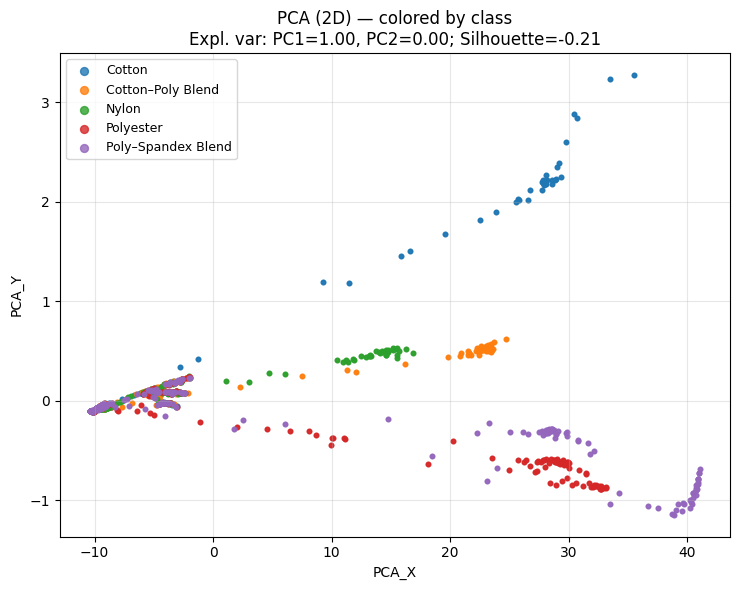

Saved: /content/drive/Shareddrives/Danika-work4/Textile/pca_analysis/pca_by_class.png


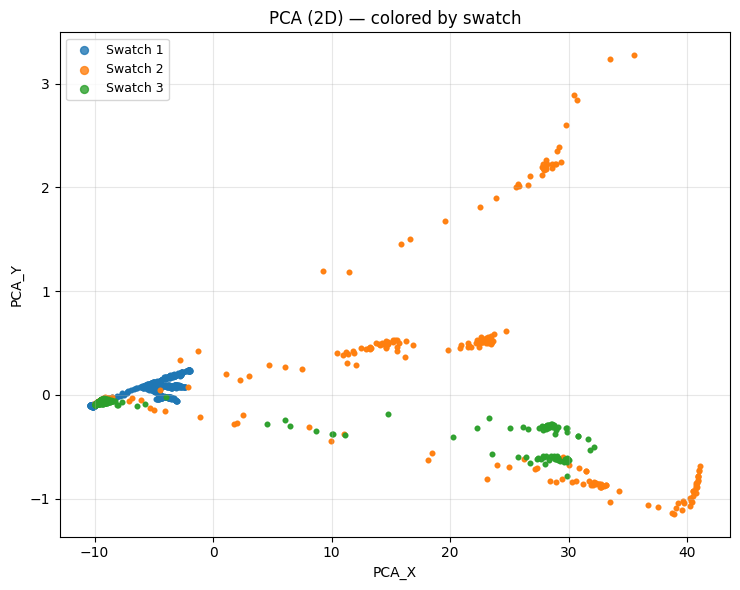

Saved: /content/drive/Shareddrives/Danika-work4/Textile/pca_analysis/pca_by_swatch.png


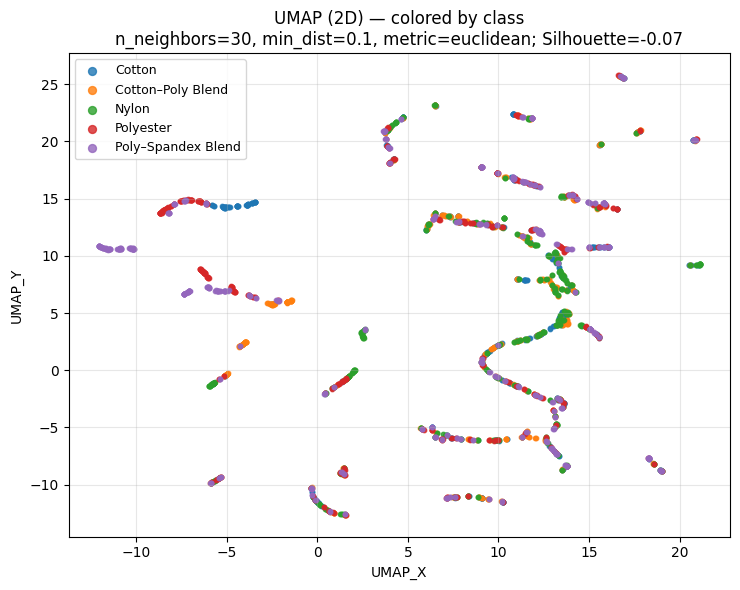

Saved: /content/drive/Shareddrives/Danika-work4/Textile/pca_analysis/umap_by_class.png


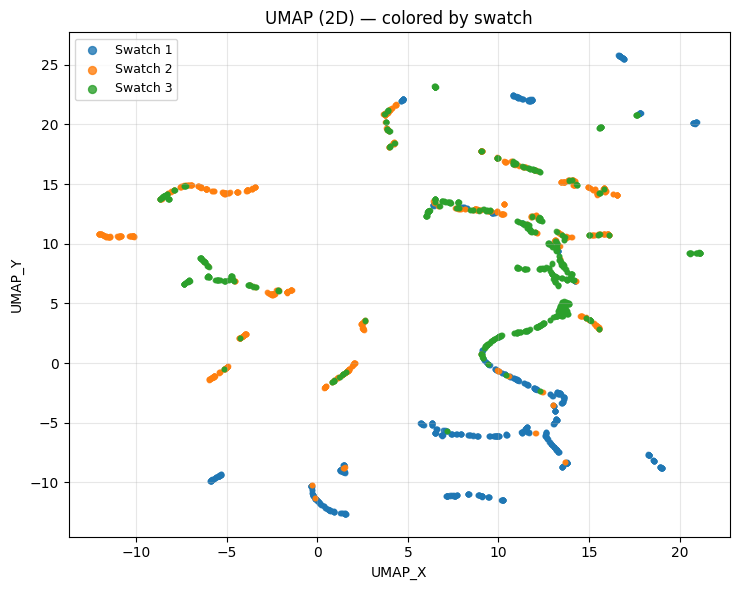

Saved: /content/drive/Shareddrives/Danika-work4/Textile/pca_analysis/umap_by_swatch.png
All done. Outputs in: /content/drive/Shareddrives/Danika-work4/Textile/pca_analysis


In [2]:
# ============================================
# PCA + UMAP from CSV spectra (no ENVI needed)
# ============================================
# What you need:
#  - One or more CSVs containing spectra (one row per spectrum)
#  - Columns:
#      class   : fabric class (e.g., 'Cotton')
#      swatch  : swatch label (e.g., 'Swatch 1')
#      id      : unique id per spectrum (optional)
#      band_*  : spectral bands (any numeric columns are treated as features)
#
# Outputs:
#  - /content/pca_umap_csv/embeddings_pca_umap.csv
#  - PCA/UMAP scatter plots colored by class & swatch
# ============================================

!pip -q install numpy pandas matplotlib scikit-learn umap-learn

import os, glob, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

try:
    import umap
    HAS_UMAP = True
except Exception:
    HAS_UMAP = False

plt.rcParams['figure.figsize'] = (7.5, 6)
plt.rcParams['savefig.dpi'] = 300

# ---------- CONFIG (EDIT THESE) ----------
DATA_DIR   = "/content/drive/Shareddrives/Danika-work4/Textile/patches_new"     # folder containing your CSV files
OUTDIR     = "/content/drive/Shareddrives/Danika-work4/Textile/pca_analysis"
META_COLUMNS = ["class", "swatch", "id"]  # rename if yours differ
UMAP_N_NEIGHBORS = 30
UMAP_MIN_DIST    = 0.1
UMAP_METRIC      = "euclidean"           # change to "cosine" if desired
RANDOM_SEED      = 123
# -----------------------------------------

os.makedirs(OUTDIR, exist_ok=True)

# --------- Load & merge all CSVs ----------
paths = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))
if not paths:
    raise FileNotFoundError(f"No CSV files found in {DATA_DIR}. Place your spectra CSVs there.")

dfs = []
for p in paths:
    df = pd.read_csv(p)
    df["__source__"] = os.path.basename(p)
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

# --------- Identify columns ---------------
# Keep metadata columns if present; everything else that is numeric = spectral features
present_meta = [c for c in META_COLUMNS if c in data.columns]
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# Spectral columns = numeric columns that are NOT metadata
spectral_cols = [c for c in num_cols if c not in present_meta]
if len(spectral_cols) < 5:
    raise ValueError(
        "Fewer than 5 numeric spectral columns detected. "
        "Check that your CSVs contain band columns (numeric)."
    )

# Fill ids if missing
if "id" not in present_meta:
    data["id"] = [f"spec_{i}" for i in range(len(data))]
    present_meta = sorted(set(present_meta + ["id"]), key=lambda x: META_COLUMNS.index(x) if x in META_COLUMNS else 99)

# Default values for missing meta columns
for m in META_COLUMNS:
    if m not in data.columns:
        data[m] = {"class": "Unknown", "swatch": "Unknown", "id": data["id"]}[m]

# Extract arrays
X = data[spectral_cols].to_numpy(dtype=float)
y_class  = data["class"].astype(str).values
y_swatch = data["swatch"].astype(str).values
ids      = data["id"].astype(str).values

print("Loaded rows:", len(data), "| Spectral dims:", X.shape[1])
print("Classes:", sorted(pd.unique(y_class)))

# --------- Standardize features -----------
scaler = StandardScaler(with_mean=True, with_std=True)
Xz = scaler.fit_transform(X)

# --------- PCA (2D) -----------------------
pca = PCA(n_components=2, random_state=RANDOM_SEED)
Xp = pca.fit_transform(Xz)
expl_var = pca.explained_variance_ratio_
print(f"PCA explained variance: PC1={expl_var[0]:.3f}, PC2={expl_var[1]:.3f}")

try:
    sil_pca = silhouette_score(Xp, y_class, metric="euclidean")
except Exception:
    sil_pca = np.nan

# --------- UMAP (2D) ----------------------
if HAS_UMAP:
    um = umap.UMAP(n_neighbors=UMAP_N_NEIGHBORS,
                   min_dist=UMAP_MIN_DIST,
                   metric=UMAP_METRIC,
                   random_state=RANDOM_SEED)
    Xu = um.fit_transform(Xz)
    try:
        sil_umap = silhouette_score(Xu, y_class, metric="euclidean")
    except Exception:
        sil_umap = np.nan
else:
    Xu = np.zeros((X.shape[0], 2))
    sil_umap = np.nan
    print("UMAP not available — install `umap-learn` to enable.")

# --------- Save embeddings CSV ------------
emb = pd.DataFrame({
    "id": ids,
    "class": y_class,
    "swatch": y_swatch,
    "pca_x": Xp[:, 0],
    "pca_y": Xp[:, 1],
    "umap_x": Xu[:, 0],
    "umap_y": Xu[:, 1],
    "__source__": data["__source__"],
})
emb_path = os.path.join(OUTDIR, "embeddings_pca_umap.csv")
emb.to_csv(emb_path, index=False)
print("Saved:", emb_path)

# --------- Plot helpers -------------------
def scatter_plot(df, xcol, ycol, labels, title, outfile):
    labs = np.unique(labels)
    plt.figure()
    for lab in labs:
        m = (labels == lab)
        plt.scatter(df.loc[m, xcol], df.loc[m, ycol], s=10, alpha=0.8, label=str(lab))
    plt.xlabel(xcol.upper()); plt.ylabel(ycol.upper())
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(markerscale=1.8, fontsize=9, frameon=True)
    plt.tight_layout()
    path = os.path.join(OUTDIR, outfile)
    plt.savefig(path); plt.show()
    print("Saved:", path)

# --------- Make plots ---------------------
scatter_plot(
    emb, "pca_x", "pca_y", emb["class"].values,
    f"PCA (2D) — colored by class\nExpl. var: PC1={expl_var[0]:.2f}, PC2={expl_var[1]:.2f}; Silhouette={sil_pca:.2f}",
    "pca_by_class.png"
)

scatter_plot(
    emb, "pca_x", "pca_y", emb["swatch"].values,
    "PCA (2D) — colored by swatch",
    "pca_by_swatch.png"
)

if HAS_UMAP:
    scatter_plot(
        emb, "umap_x", "umap_y", emb["class"].values,
        f"UMAP (2D) — colored by class\nn_neighbors={UMAP_N_NEIGHBORS}, min_dist={UMAP_MIN_DIST}, metric={UMAP_METRIC}; Silhouette={sil_umap:.2f}",
        "umap_by_class.png"
    )
    scatter_plot(
        emb, "umap_x", "umap_y", emb["swatch"].values,
        "UMAP (2D) — colored by swatch",
        "umap_by_swatch.png"
    )

# --------- Manifest -----------------------
manifest = {
    "outdir": OUTDIR,
    "files": sorted(os.listdir(OUTDIR)),
    "meta_columns": present_meta,
    "n_rows": int(len(data)),
    "n_bands": int(X.shape[1]),
    "umap": {
        "enabled": bool(HAS_UMAP),
        "n_neighbors": UMAP_N_NEIGHBORS,
        "min_dist": UMAP_MIN_DIST,
        "metric": UMAP_METRIC
    },
}
with open(os.path.join(OUTDIR, "pca_umap_manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2)

print("All done. Outputs in:", OUTDIR)
